In [1]:
import os
import torch
import torch.nn as nn
import pickle
import pandas as pd
import glob
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
file_list = glob.glob("gdrive/MyDrive/Scalping/Data/*")
len(file_list)
print(file_list)

['gdrive/MyDrive/Scalping/Data/CEM_data.p']


In [4]:
with open("gdrive/MyDrive/Scalping/Data/CEM_data.p", "rb") as f :
  attentions, preds, ori_targets = pickle.load(f)

In [38]:
print(attentions.shape)
print(preds.shape)
print(ori_targets.shape)

(79400, 10, 60, 1)
(79400, 10, 1)
(79400, 10, 1)


In [39]:
def make_target(ori_output, ori_target) :
  # target_c 를 만드는 함수
  # target_c = tanh(ori_output / ori_target - 1)
  # 만약 output이 rable과 같다면 ori_output / ori_target - 1 = 0    => target_c = 0
  # 만약 output이 rable보다 크다면 ori_output / ori_target - 1 > 0  => target_c > 0
  # 만약 output이 rable보다 작다면 ori_output / ori_target - 1 < 0  => target_c < 0
  # CEM은 이 c 값을 예측하여 
  #       => 0에 가까운 값이면 해당 예측기가 올바르게 작동한다고 판단
  #       => 1에 가까울수록 해당 예측기가 실제보다 (종료가를) 크게 예측할 확률이 크다고 판단
  #       => -1에 가까울수록 해당 예측기가 실제보다 (종료가를) 작게 예측할 확률이 크다고 판단
  t = (ori_output / ori_target) - 1
  return np.tanh(t)

In [40]:
# 실제 데이터에 -1을 주지 말고 데이터 레이블 자체는 그냥 float로
# 마지막에 그래프 그릴 때 pred 값과 target값에 [*2 -1] 해서 보기좋게 그려보자
def make_target2(ori_output, ori_target) :
  t = np.abs(ori_output - ori_target) # 이 값이 클수록, 해당 예측기는 실제 값보다 잘못 예측할 확률이 큰 것
  return t

In [41]:
new_x = []
new_y = []
for i in range(len(attentions)) :
  x1 = np.array(attentions[i])
  x2 = np.array(preds[i])
  x = np.concatenate((x1.squeeze(), x2), axis=1)
  y = make_target2(preds[i], ori_targets[i])
  new_x.append(x)
  new_y.append(y)
new_x = np.array(new_x)
new_y = np.array(new_y)
print(new_x.shape)
print(new_y.shape)

(79400, 10, 61)
(79400, 10, 1)


In [42]:
x_train_data = new_x[:75000]
y_train_data = new_y[:75000]
x_test_data = new_x[75000:]
y_test_data = new_y[75000:]

In [43]:
class CEM(nn.Module) :
  def __init__(self, *args, **kwargs) : 
    super(CEM, self).__init__()
    self.fc1 = nn.Linear(61, 32)
    self.fc2 = nn.Linear(32, 16)
    self.fc3 = nn.Linear(16, 4)
    self.fc4 = nn.Linear(4, 1)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()
  
  def forward(self, inputs) :
    x = inputs
    l1 = self.relu(self.fc1(x))
    l2 = self.relu(self.fc2(l1))
    l3 = self.relu(self.fc3(l2))
    o = self.fc4(l3)

    return o

model = CEM()

In [44]:
def sample_train_data(input_list, target_list, shuffle = True) : 
  total_num = len(input_list)
  input_idxs = np.arange(total_num)
  if shuffle :
    np.random.shuffle(input_idxs)
  
  x = []
  y = []
  used_idx = []

  for idx in input_idxs : 
    cur_data = input_list[idx]
    cur_target = target_list[idx]
    ori_batch_len = len(cur_target)
    i = np.random.randint(ori_batch_len, size=1)
    used_idx.append(i)
    x.append(cur_data[i])
    y.append(cur_target[i])
  
  used_idx = np.array(used_idx)
  x = np.array(x)
  y = np.array(y)

  return x, y, used_idx

In [45]:
def train_data_loader(X, Y, batch_size=1, shuffle=True) :
  x, y, used_idx = sample_train_data(X, Y, shuffle)
  print(x.shape)
  print(y.shape)
  print(used_idx.shape)
  total_len = len(x)
  for i in range(0, total_len, batch_size) :
    x_ = torch.Tensor(x[i]).float()
    y_ = torch.Tensor(y[i]).float()
    idx_ = used_idx[i]
    yield x_, y_, idx_

In [46]:
data_loader = train_data_loader(x_train_data, y_train_data)
test_data_loader = train_data_loader(x_test_data, y_test_data)

In [47]:
class CEMDataset(torch.utils.data.Dataset) : 
  def __init__(self, X, Y) : 
    self.input_data = torch.from_numpy(X).float()
    self.target_data = torch.from_numpy(Y).float()
  
  def __len__(self) :
    return len(self.input_data)

  def __getitem__(self, idx) :
    if torch.is_tensor(idx) :
      idx = idx.tolist()

    x = self.input_data[idx]
    y = self.target_data[idx]
    return x, y

In [48]:
train_dataset = CEMDataset(x_train_data, y_train_data)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

In [49]:
import torch.optim as optim
import torch.nn.functional as F

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [50]:
train_pred = []
train_target = []
train_used_idx = []

model.train()
for idx, (input, target, used_idx) in enumerate(data_loader) : 
  pred = model(input)
  target_c = target
  train_pred.append(pred)
  train_target.append(target_c)
  train_used_idx.append(used_idx)

  cost = F.mse_loss(pred, target_c)
  if not torch.isfinite(cost) :
    print("loss is too big")
    exit
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

  if idx % 10000 == 0 : 
    print('Epoch {:4d}/{} Cost: {:.6f}'.format(idx+1, 100, cost.item()))

(75000, 1, 61)
(75000, 1, 1)
(75000, 1)
Epoch    1/100 Cost: 0.027717
Epoch 10001/100 Cost: 0.000045
Epoch 20001/100 Cost: 0.000099
Epoch 30001/100 Cost: 0.002881
Epoch 40001/100 Cost: 0.000229
Epoch 50001/100 Cost: 0.000117
Epoch 60001/100 Cost: 0.000127
Epoch 70001/100 Cost: 0.000131


In [51]:
test_pred = []
test_target = []
test_used_idx = []
model.eval()
for idx, (input, target, used_idx) in enumerate(test_data_loader) : 
  pred = model(input)
  target_c = target
  test_pred.append(pred)
  test_target.append(target_c)
  test_used_idx.append(used_idx)


(4400, 1, 61)
(4400, 1, 1)
(4400, 1)


In [52]:
print(len(train_used_idx))
train_used_idx = np.array(train_used_idx)
train_used_idx.shape
print(len(test_used_idx))

75000
4400


In [53]:
import matplotlib.pyplot as plt

In [60]:
train_predictor_outputs = []
train_original_targets = []
for i in range(len(preds[:75000])) : 
  used_batch_idx = train_used_idx[i]
  prediction = preds[i][used_batch_idx]
  target = ori_targets[i][used_batch_idx]
  train_predictor_outputs.append(prediction.squeeze())
  train_original_targets.append(target.squeeze())

test_predictor_outputs = []
test_origianl_targets = []
for idx, pred in enumerate(preds[75000:]) :
  used_batch_idx = test_used_idx[idx]
  prediction = pred[used_batch_idx]
  test_predictor_outputs.append(prediction.squeeze())
for idx, tar in enumerate(ori_targets[75000:]) :
  used_batch_idx = test_used_idx[idx]
  target = tar[used_batch_idx]
  test_origianl_targets.append(target.squeeze())


In [61]:
print(test_predictor_outputs[0].shape)
train_predictor_outputs[0].shape


()


()

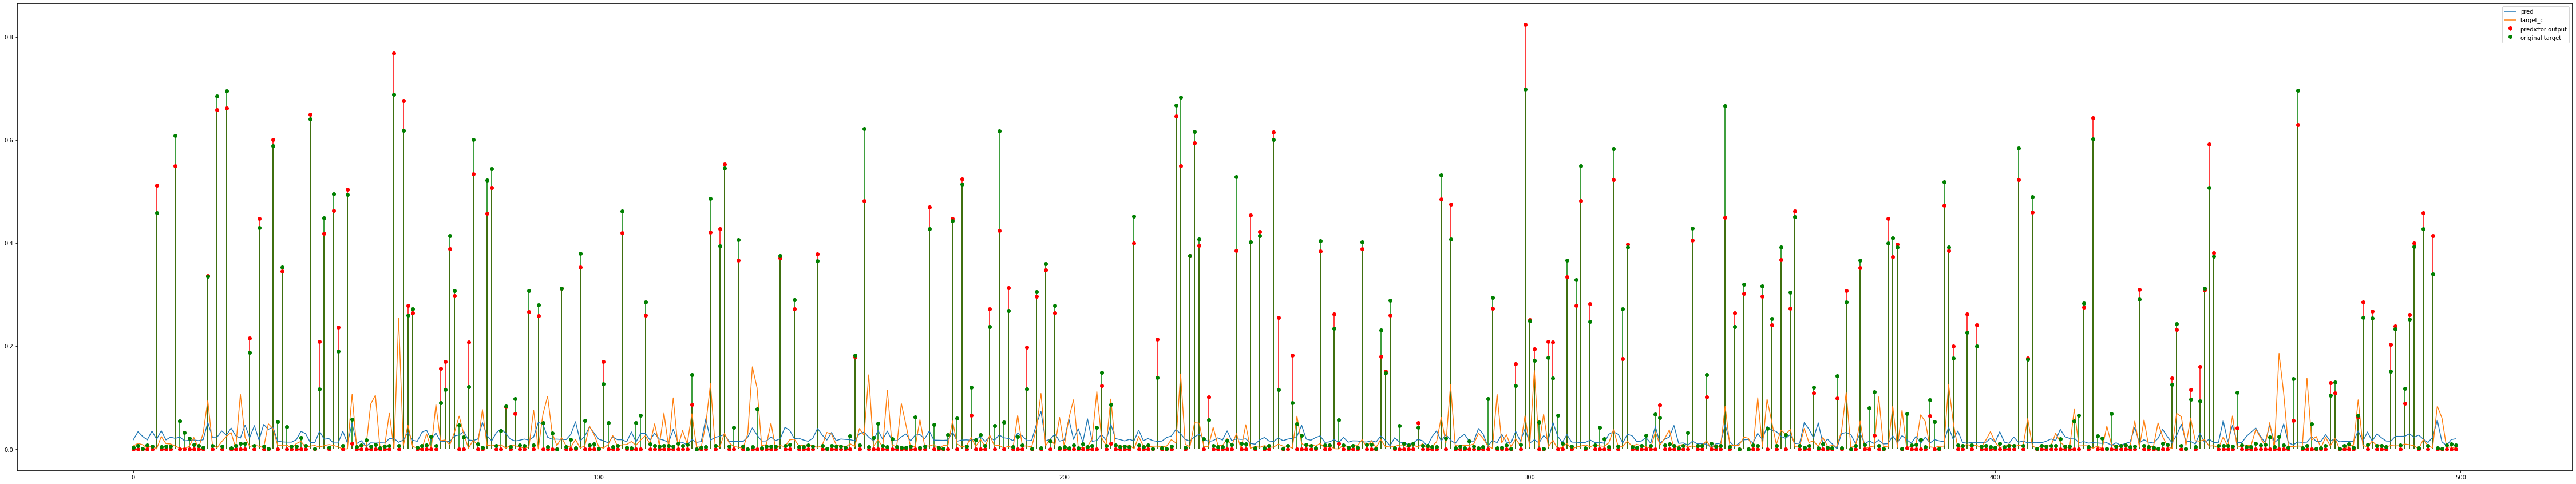

In [62]:
plt.figure(figsize=(80,15))
plt.plot(train_pred[74500:], label="pred")
plt.plot(train_target[74500:], label="target_c")
markerline1, stemlines1, baseline1 = plt.stem(train_predictor_outputs[74500:], label="predictor output", use_line_collection=True)
markerline1.set_color('red')
stemlines1.set_color('red')
baseline1.set_visible(False)
markerline2, stemlines2, baseline2 = plt.stem(train_original_targets[74500:], label="original target", use_line_collection=True)
markerline2.set_color('green')
stemlines2.set_color('green')
baseline2.set_visible(False)
plt.legend()

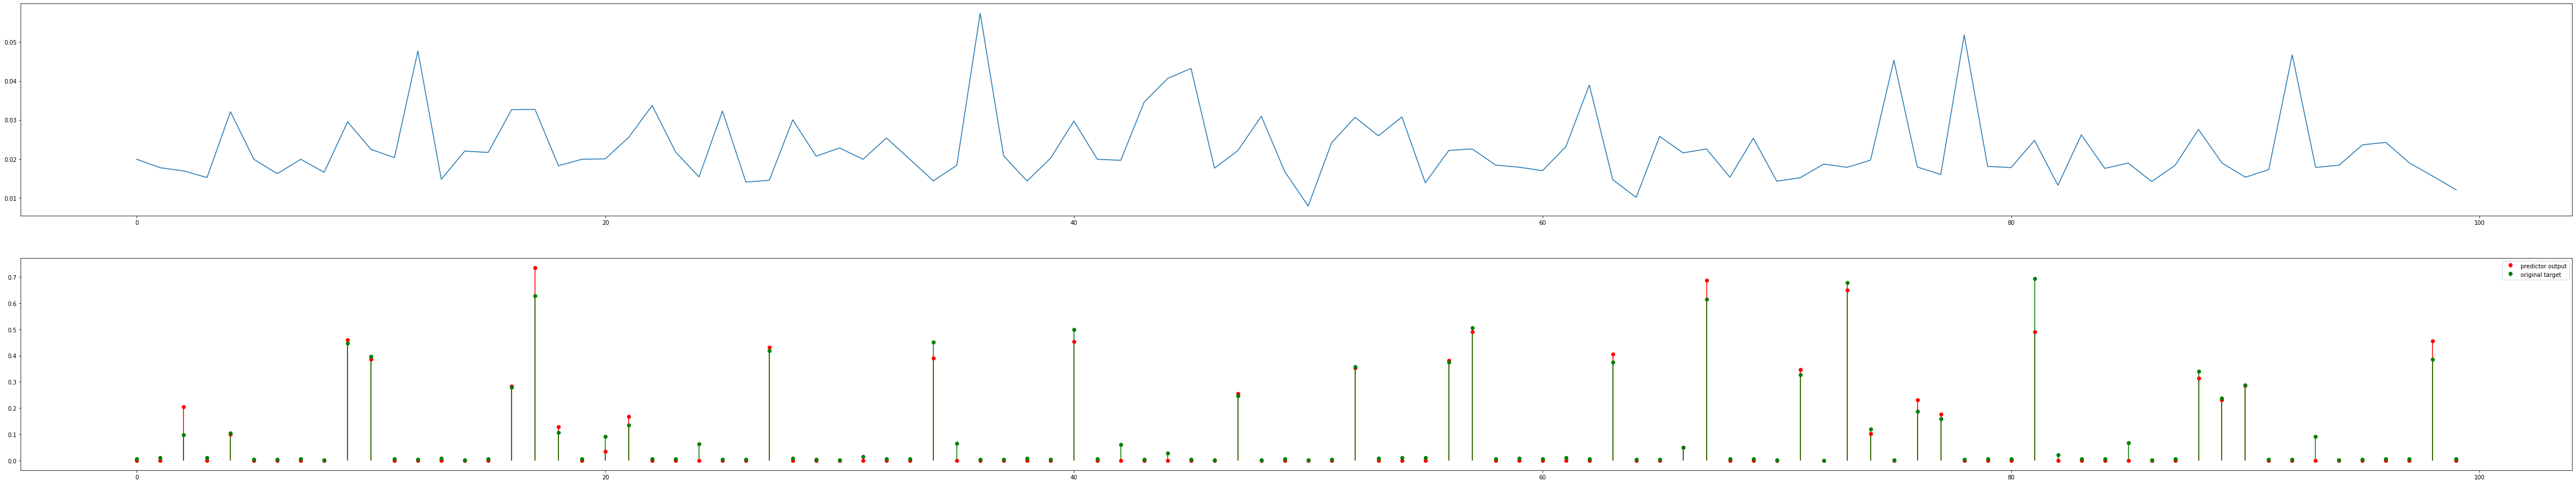

In [68]:
plt.figure(figsize=(80,15))
plt.subplot(2,1,1)
plt.plot(test_pred[:100], label="pred")
#plt.plot(test_target, label="target_c")
plt.subplot(2,1,2)
markerline1, stemlines1, baseline1 = plt.stem(test_predictor_outputs[:100], label="predictor output", use_line_collection=True)
markerline1.set_color('red')
stemlines1.set_color('red')
baseline1.set_visible(False)
markerline2, stemlines2, baseline2 = plt.stem(test_origianl_targets[:100], label="original target", use_line_collection=True)
markerline2.set_color('green')
stemlines2.set_color('green')
baseline2.set_visible(False)
plt.legend()
